# Segmenting Micrographs Using the Louvain method for Community Detection  (Part II) #

This notebook produces segmentation masks using the results from the Louvain approach.

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import transform
from data_tools import read_chip_database
import distinctipy # might be a good idea to revert back to using this
import matplotlib.cm as cm
import matplotlib

2024-05-31 16:43:54.900708: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 16:43:57.375571: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#### Plotting parameters ####
my_dpi=150
W=12
H=12

min_cluster_members = 3
cmap = 'tab10'

def format_chips(results, shape, dim):
    chips = np.zeros(np.append(shape, [3]), dtype='int')
    
    for i, drow in results.sort_values(['row','col']).iterrows():
        r = drow['row']
        rstart = r+((dim-1)*r)
        rend = r+((dim-1)*r)+dim
        
        c = drow['col']
        cstart = c+((dim-1)*c)
        cend = c+((dim-1)*c)+dim
    
        img = np.array(drow['image']).reshape(dim, dim, 3)
        chips[rstart:rend,cstart:cend,:] = img
    return chips

In [3]:
# path to desired h5 file
h5_path = 'data.h5'

# name of sample/title you want to use for storing data
name = '0.1 dpa LFO pristine'

# path to folder where final results will be stored
results_path = 'results'

# path to where prediction data is stored
predictions_path = os.path.join(results_path, 'mode_unimodal_predictions.csv')

In [4]:
cutoff_metric = "mode"

max cluster idx 7


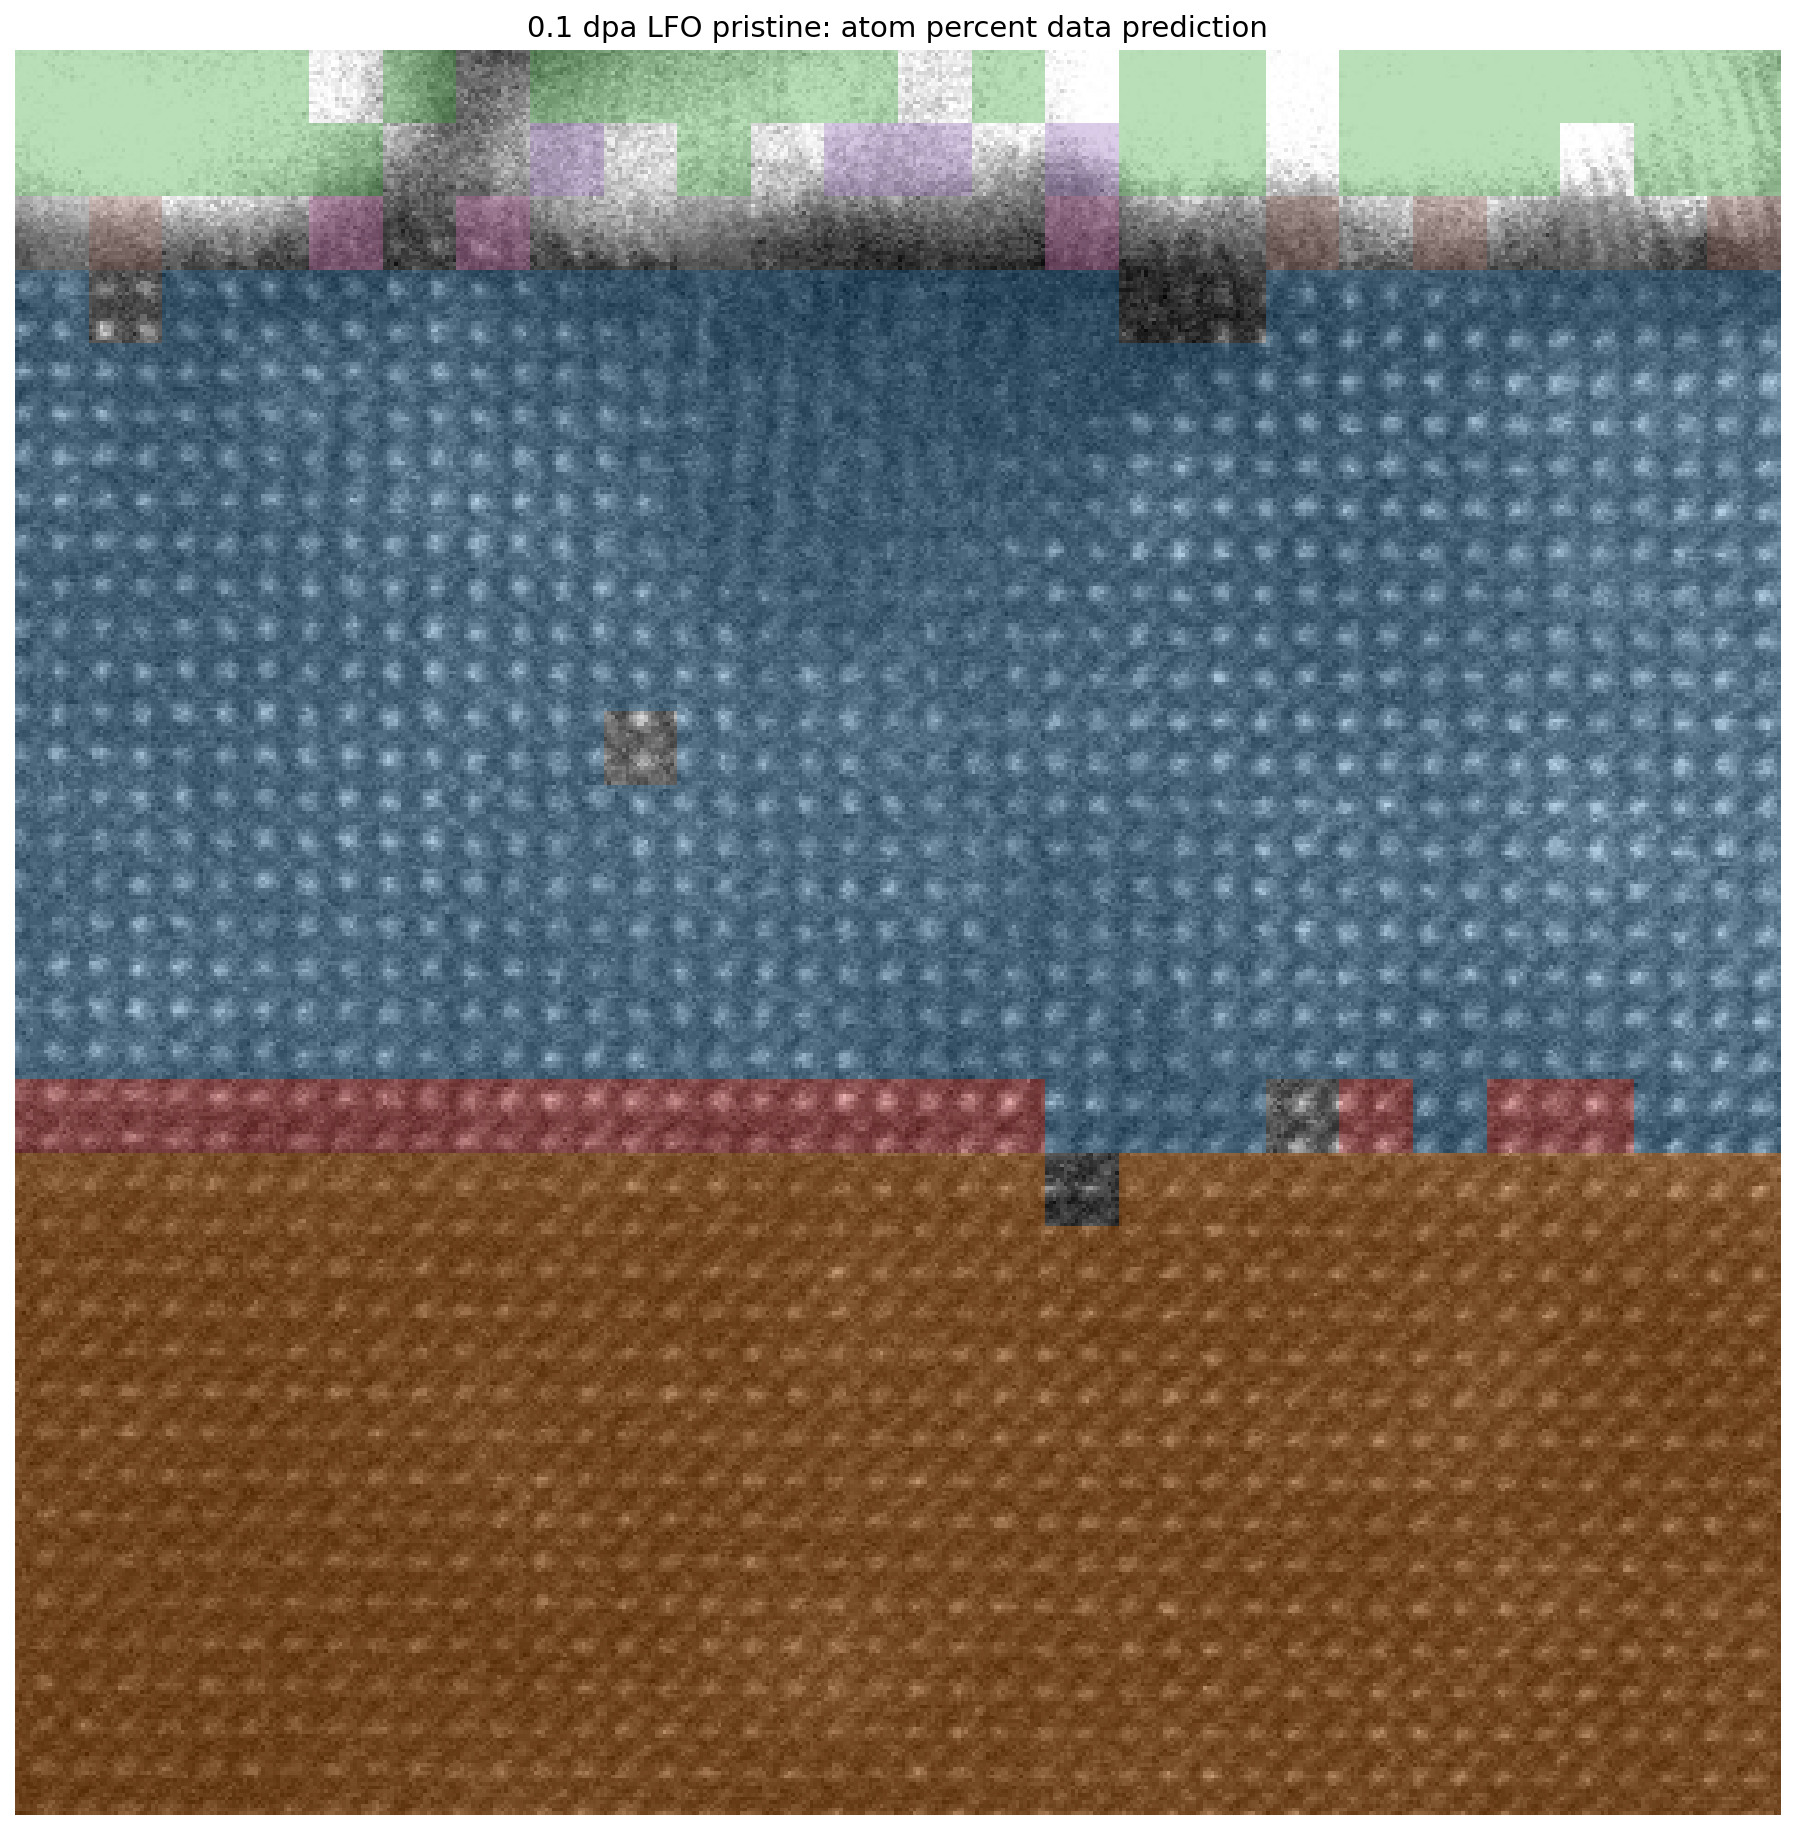

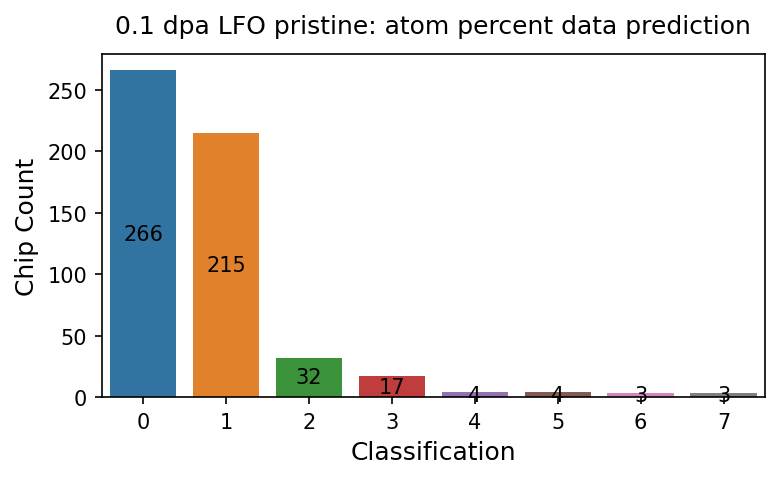

max cluster idx 2


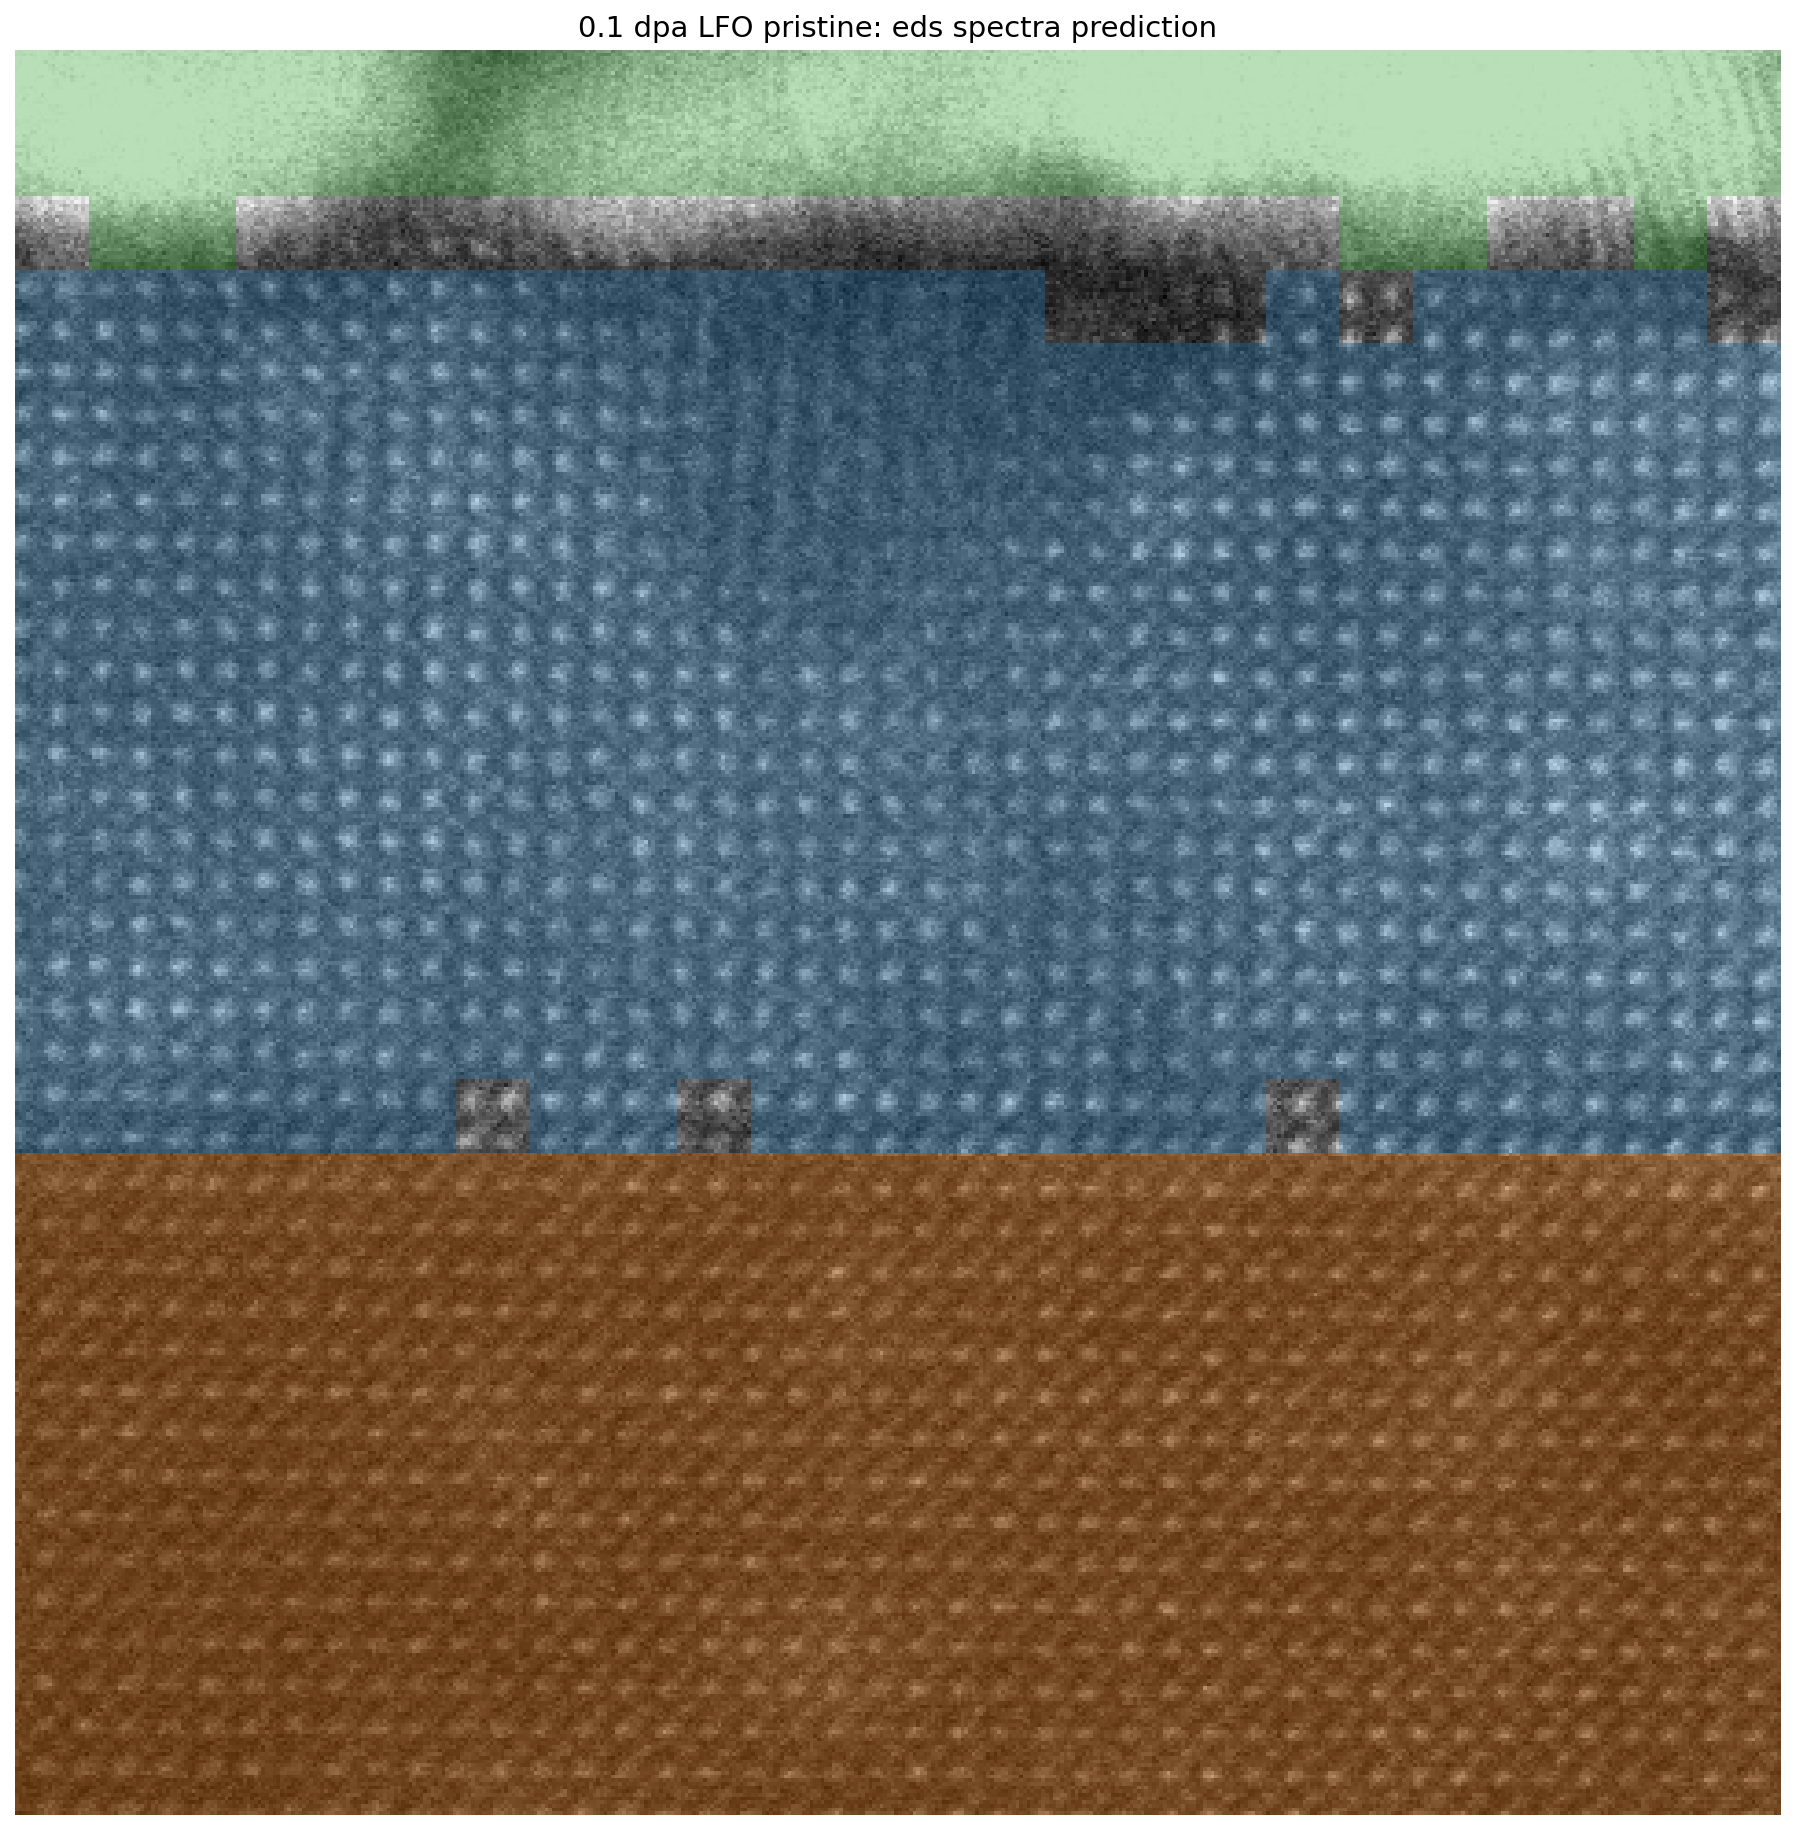

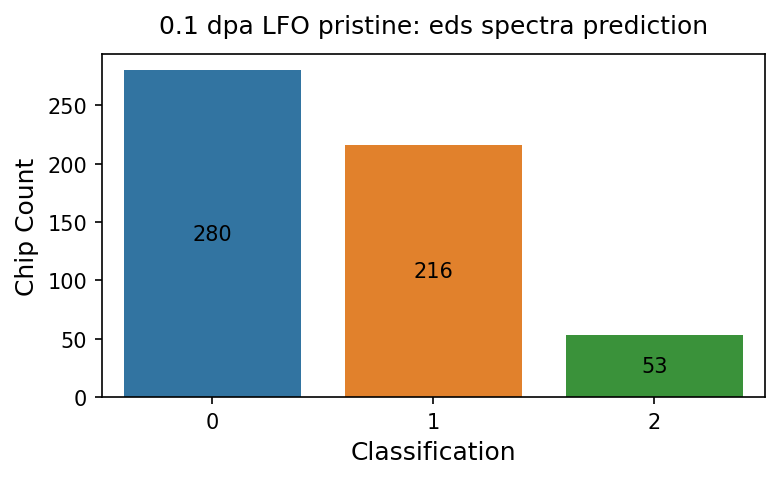

max cluster idx 3


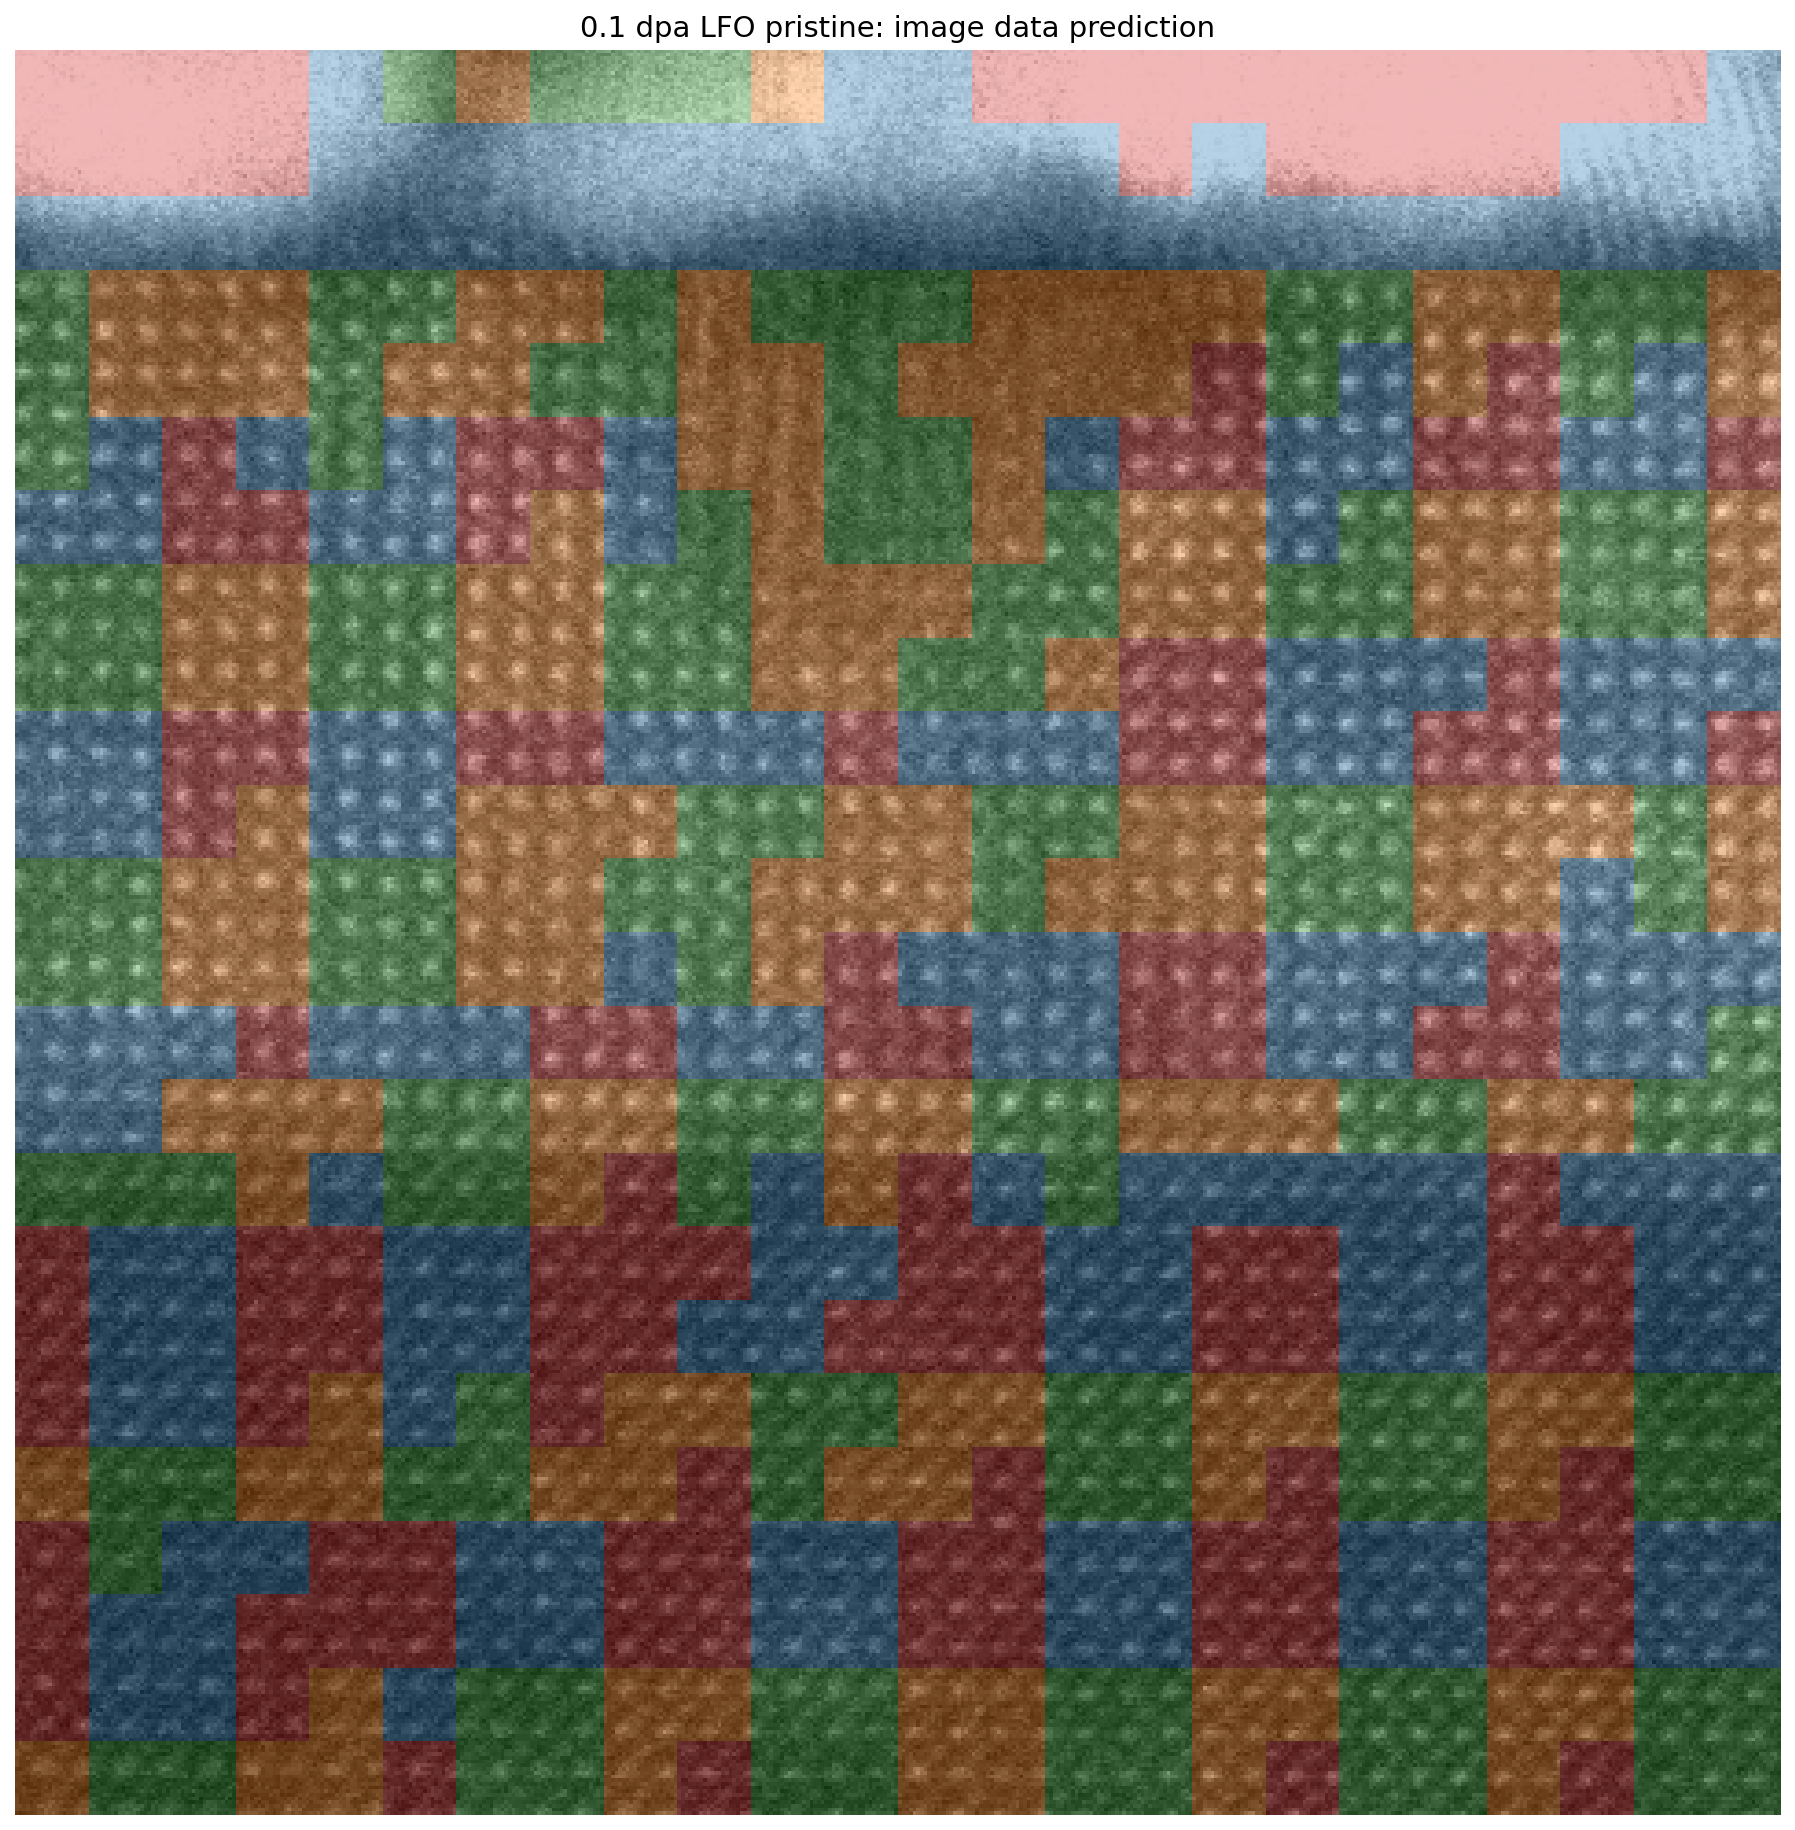

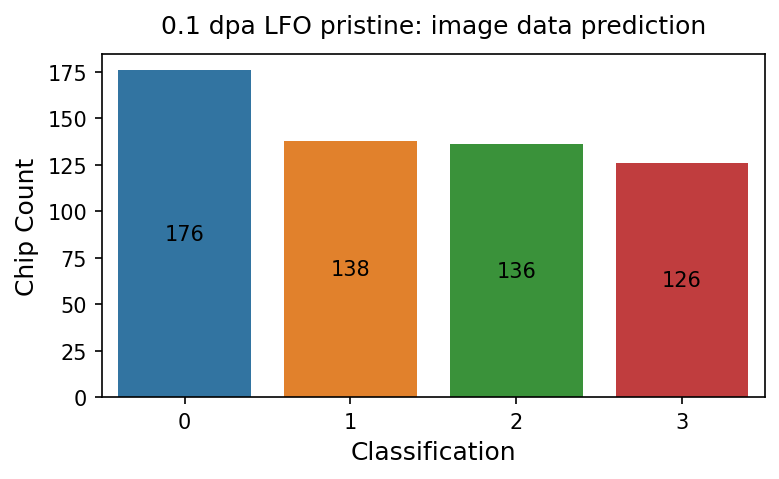

max cluster idx 3


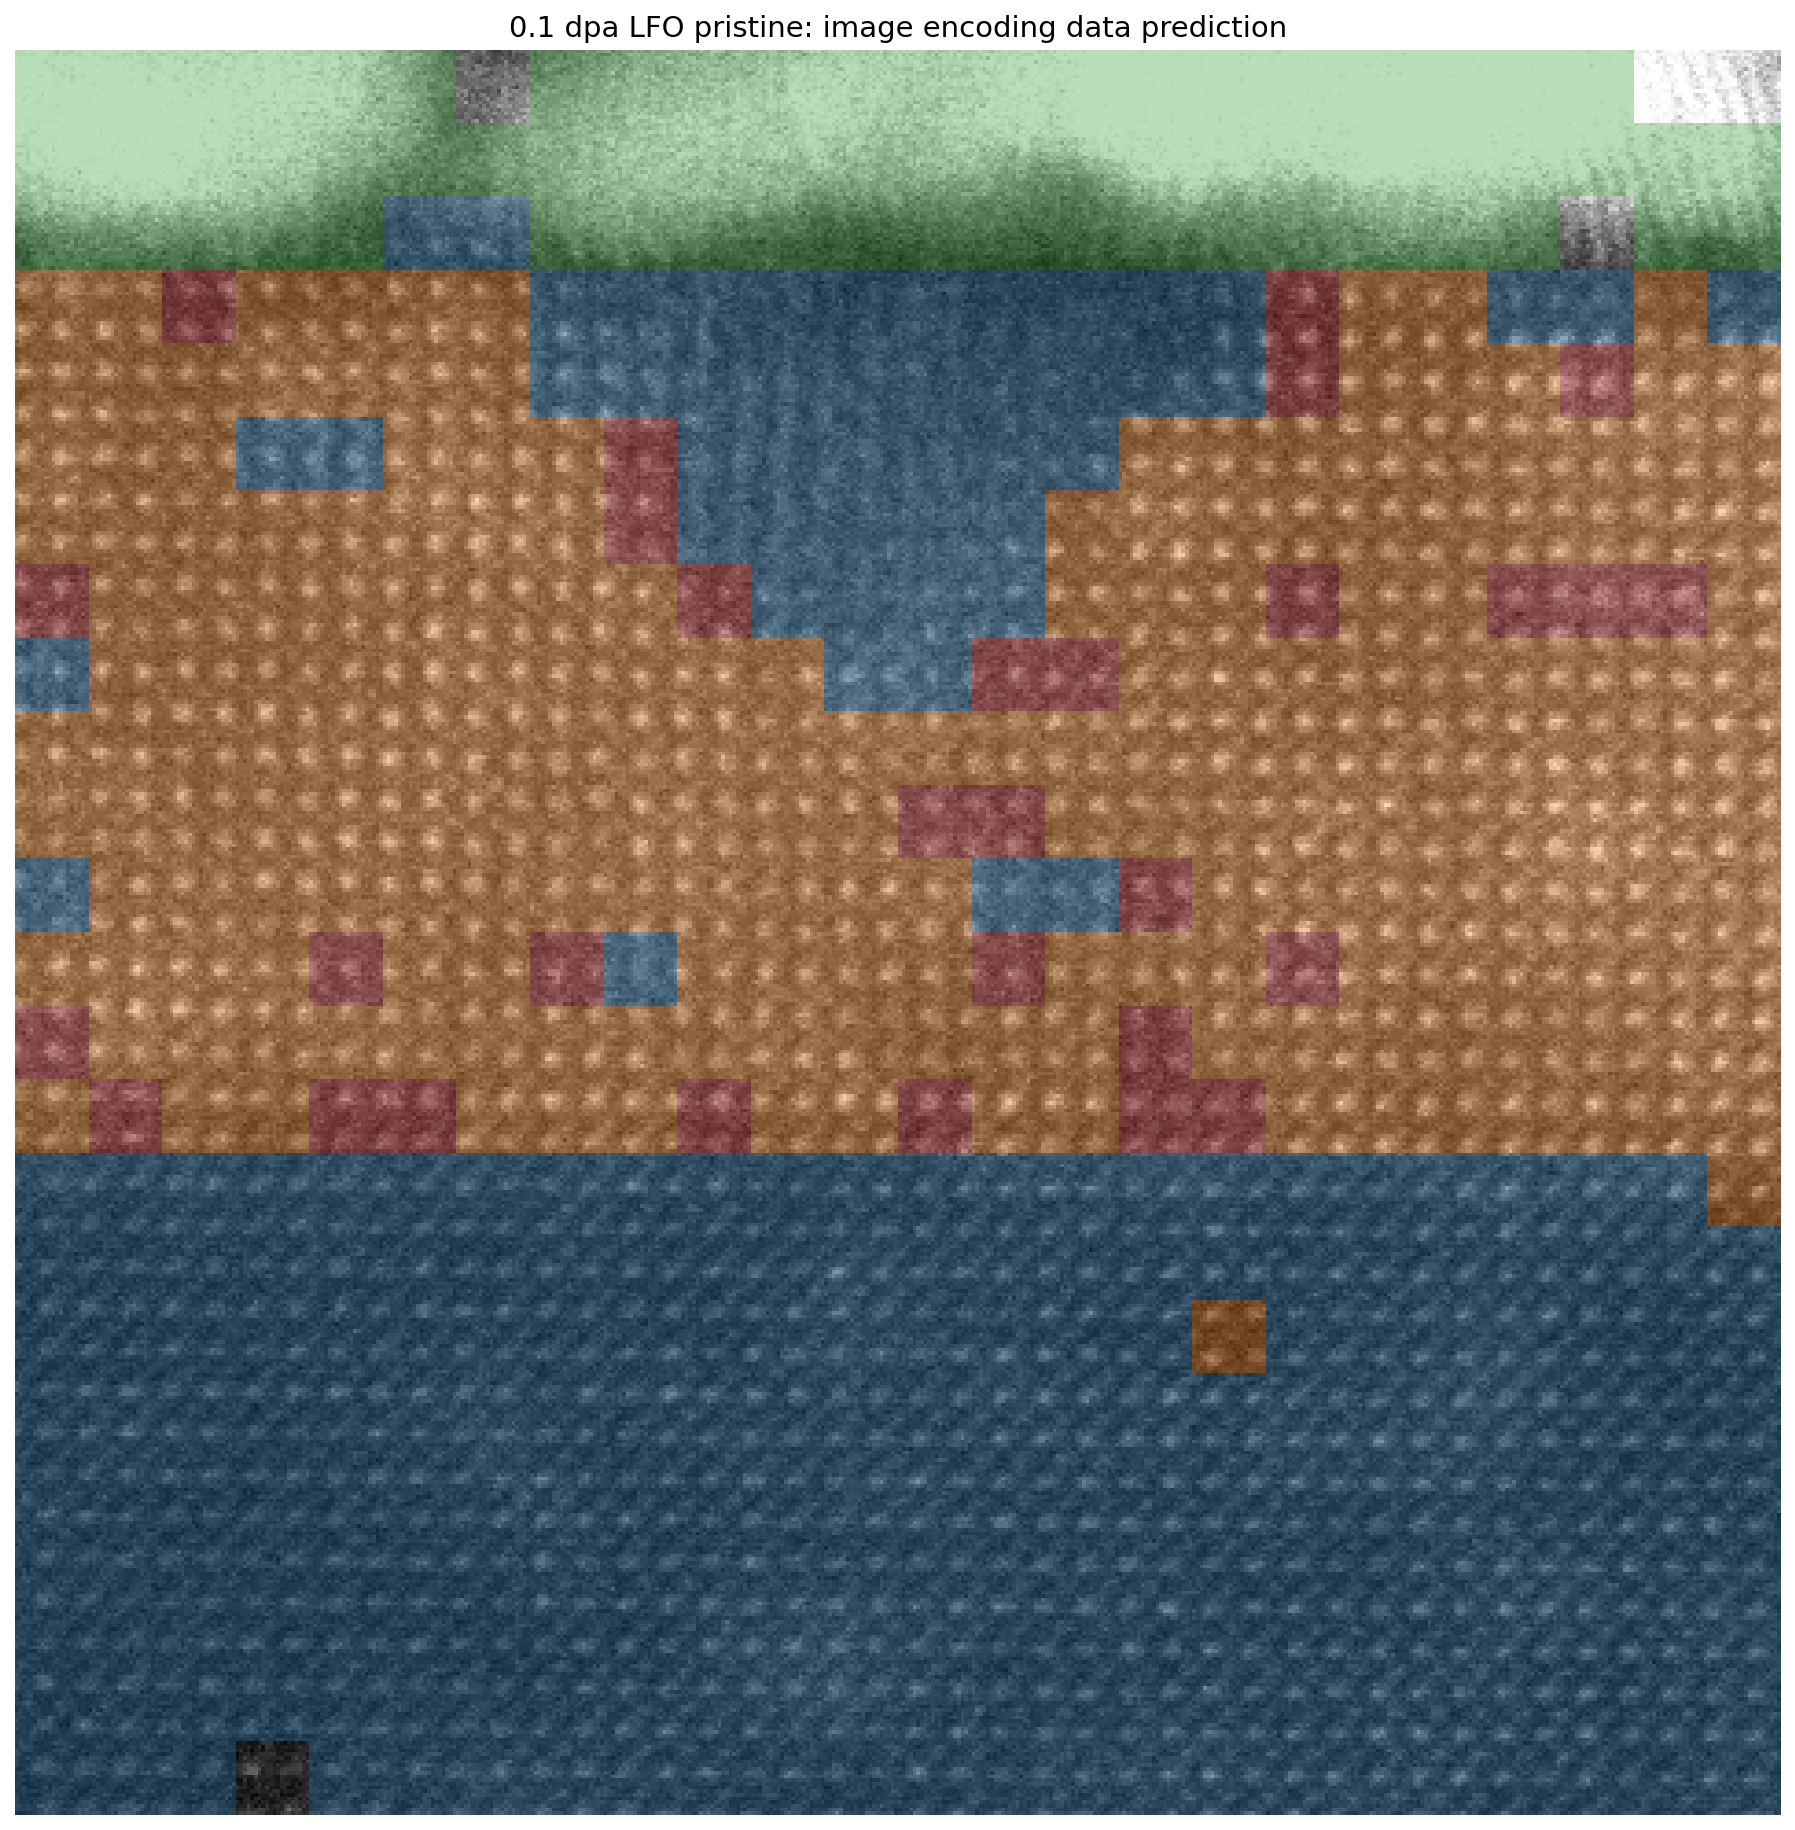

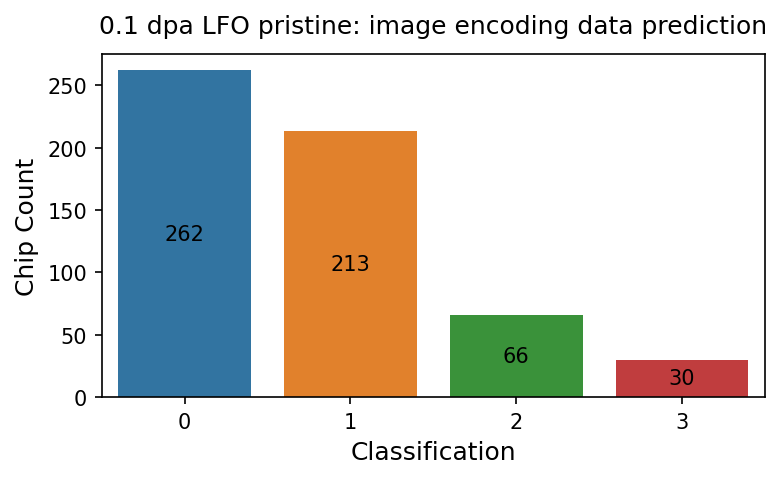

In [5]:
images = read_chip_database(h5_path)[['chip ID', 'image data']]
results = pd.read_csv(predictions_path).drop(['Unnamed: 0'], axis=1)
modalities = results.columns[1:]
results = results.merge(images, left_on='chip ID', right_on='chip ID').rename(columns={'image data': 'image'})
for modality in modalities:
    n_rows=len([x for x in results['chip ID'].tolist() if 'R0C' in x])
    n_columns=len([x for x in results['chip ID'].tolist() if x[-2:]=='C0'])

    results['row']=results['chip ID'].apply(lambda x: int(x.split('C')[0][1:]))
    results['col']=results['chip ID'].apply(lambda x: int(x.split('C')[1]))

    grid=np.zeros((results['col'].max()+1,results['row'].max()+1), dtype='int')
    for c in results[modality].value_counts().index:
        grid[results.loc[results[modality]==c]['row'].to_numpy(),results.loc[results[modality]==c]['col'].to_numpy()]=c

    ## remove clusters with 1 memeber
    vc=results[modality].value_counts()

    max_cluster_idx = len(vc.loc[vc>=min_cluster_members])-1
    print('max cluster idx', max_cluster_idx)

    # image plot
    fig=plt.figure(figsize=(W, H), dpi=my_dpi)
    ax = fig.gca()
    plt.title(f'{name}: {modality}', fontsize=14)

    # resize to fit image
    dim = int(np.sqrt(np.array(results.iloc[0]['image']).reshape(-1,3).shape[0]))
    updim = (int(n_rows*dim), int(n_columns*dim))
    g = transform.resize_local_mean(grid, updim, preserve_range=True).astype('int')

    # apply mask
    g=np.ma.masked_where(g>max_cluster_idx, g)

    chips = format_chips(results, shape=np.array(updim), dim=dim)
    ax.imshow(chips, interpolation='none', cmap=cm.gray)
    ax.imshow(g, alpha=0.33, cmap=cmap, interpolation='none', 
          norm = matplotlib.colors.BoundaryNorm(range(0,max_cluster_idx+1), ncolors=max_cluster_idx)
          )

    plt.axis('off')
    plt.margins(0.1)
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.savefig(os.path.join(results_path, name + '_' + modality.replace(' ', '_') + '_' + cutoff_metric + '_mask.png'), dpi=75)
    plt.show()

    # count plot
    countplot_results = results.loc[results[modality]<=max_cluster_idx].copy()
    fig=plt.figure(figsize=(5,3), dpi=my_dpi)
    ax=sns.countplot(countplot_results.sort_values(modality), x=modality, palette=cmap)
    ax.bar_label(ax.containers[0], label_type='center')
    plt.title(f'{name}: {modality}', fontsize=12, pad=10)
    plt.ylabel('Chip Count',fontsize=12)
    plt.xlabel('Classification',fontsize=12)
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.savefig(os.path.join(results_path, name + '_' + modality.replace(' ', '_') + '_' + cutoff_metric + '.png'), dpi=75)
    plt.show()